# 5.SQL and Dataframes

References:

* Spark-SQL, <https://spark.apache.org/docs/latest/sql-programming-guide.html#datasets-and-dataframes>


# 5.1  Example Walkthrough
Follow the Spark SQL and Dataframes Examples below!

### Initialize PySpark

First, we use the findspark package to initialize PySpark.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os
# Initialize PySpark
APP_NAME = "PySpark Dataframes and Performance"
SPARK_MASTER="spark://mpp3r01c03s03.cos.lrz.de:7077"
try:
    sc and spark
except NameError as e:
  #import findspark
  #findspark.init()
    import pyspark
    import pyspark.sql
    from pyspark.sql import Row
    conf=pyspark.SparkConf().setAppName(APP_NAME).set("spark.cores.max", "8")
    sc = pyspark.SparkContext(master=SPARK_MASTER, conf=conf)
    spark = pyspark.sql.SparkSession(sc).builder.appName(APP_NAME).getOrCreate()

print("PySpark initiated...")

PySpark initiated...


### Hello, World!

Loading data, mapping it and collecting the records into RAM...

In [2]:
# Load the text file using the SparkContext
csv_lines = sc.textFile("../data/example.csv")

# Map the data to split the lines into a list
data = csv_lines.map(lambda line: line.split(","))

# Collect the dataset into local RAM
data.collect()

[['Russell Jurney', 'Relato', 'CEO'],
 ['Florian Liebert', 'Mesosphere', 'CEO'],
 ['Don Brown', 'Rocana', 'CIO'],
 ['Steve Jobs', 'Apple', 'CEO'],
 ['Donald Trump', 'The Trump Organization', 'CEO'],
 ['Russell Jurney', 'Data Syndrome', 'Principal Consultant']]

### Creating Rows

Creating `pyspark.sql.Rows` out of your data so you can create DataFrames...

In [3]:
# Convert the CSV into a pyspark.sql.Row
def csv_to_row(line):
    parts = line.split(",")
    row = Row(
      name=parts[0],
      company=parts[1],
      title=parts[2]
    )
    return row

# Apply the function to get rows in an RDD
rows = csv_lines.map(csv_to_row)

### Creating DataFrames from RDDs

Using the `RDD.toDF()` method to create a dataframe, registering the `DataFrame` as a temporary table with Spark SQL, and counting the jobs per person using Spark SQL.

In [4]:
# Convert to a pyspark.sql.DataFrame
rows_df = rows.toDF()

# Register the DataFrame for Spark SQL
rows_df.registerTempTable("executives")

# Generate a new DataFrame with SQL using the SparkSession
job_counts = spark.sql("""
SELECT
  name,
  COUNT(*) AS total
  FROM executives
  GROUP BY name
""")
job_counts.show()

# Go back to an RDD
job_counts.rdd.collect()

+---------------+-----+
|           name|total|
+---------------+-----+
|   Donald Trump|    1|
|Florian Liebert|    1|
|      Don Brown|    1|
| Russell Jurney|    2|
|     Steve Jobs|    1|
+---------------+-----+



[Row(name='Donald Trump', total=1),
 Row(name='Florian Liebert', total=1),
 Row(name='Don Brown', total=1),
 Row(name='Russell Jurney', total=2),
 Row(name='Steve Jobs', total=1)]

# 5.2-5.4 NASA DataSet

5.2 Create a Spark-SQL table with fields for IP/Host and Response Code from the NASA Log file! 

In [7]:
%%time
from pyspark.sql import Row
nasa_lines = sc.textFile("../data/nasa/NASA_access_log_Jul95")
spark_dataframe=nasa_lines.map(lambda a: Row(host=a.split()[0], response_code=a.split()[-2] if len(a.split())>2 else "No Value")).toDF()
spark_dataframe.registerTempTable("nasa")
spark_dataframe.show()

+--------------------+-------------+
|                host|response_code|
+--------------------+-------------+
|        199.72.81.55|          200|
|unicomp6.unicomp.net|          200|
|      199.120.110.21|          200|
|  burger.letters.com|          304|
|      199.120.110.21|          200|
|  burger.letters.com|          304|
|  burger.letters.com|          200|
|     205.212.115.106|          200|
|         d104.aa.net|          200|
|      129.94.144.152|          200|
|unicomp6.unicomp.net|          200|
|unicomp6.unicomp.net|          200|
|unicomp6.unicomp.net|          200|
|         d104.aa.net|          200|
|         d104.aa.net|          200|
|         d104.aa.net|          200|
|      129.94.144.152|          304|
|      199.120.110.21|          200|
|ppptky391.asahi-n...|          200|
|  net-1-141.eden.com|          200|
+--------------------+-------------+
only showing top 20 rows

CPU times: user 792 ms, sys: 170 ms, total: 962 ms
Wall time: 29.9 s


5.3 Run an SQL query that outputs the number of occurrences of each HTTP response code!

In [4]:
%%time
results = spark.sql("""select response_code, count(*) as count from nasa group by response_code""").toPandas()

CPU times: user 82.4 ms, sys: 38 ms, total: 120 ms
Wall time: 40.4 s


5.4 Cachen Sie den Dataframe und führen Sie dieselbe Query nochmals aus! Messen Sie die Laufzeit für das Cachen und für die Ausführungszeit der Query!

In [8]:
%%time
spark_dataframe.cache()
spark_dataframe.count()

CPU times: user 7.3 ms, sys: 11.9 ms, total: 19.2 ms
Wall time: 30.8 s


In [5]:
%%time
results = spark.sql("""select response_code, count(*) as count from nasa group by response_code""").toPandas()

CPU times: user 75.4 ms, sys: 18.3 ms, total: 93.7 ms
Wall time: 2.65 s


5.5 Führen Sie diesselbe Query mit/ohne Cache und 8, 16 Cores aus! Dokumentieren und erklären Sie das Ergebnis!

In [ ]:
results = spark.sql("""select response_code, count(*) as count from nasa group by response_code""").toPandas()

### 5.6 Weak Scaling: 
* Create two RDD with 2x and 4x of the size of the NASA log dataset! Persist the dataset in the Spark Cache!
* Measure and plot the response times for all 3 datasets (1x, 2x, 4x)!

In [ ]:
sdf2x = spark_dataframe
for i in range(1): sdf2x = sdf2x.union(sdf2x)
sdf2x.cache()

sdf4x = spark_dataframe
for i in range(2): sdf4x = sdf4x.union(sdf4x)
sdf4x.cache()

sdf8x = spark_dataframe
for i in range(3): sdf8x = sdf8x.union(sdf8x)
sdf8x.cache()

sdf16x = spark_dataframe
for i in range(4): sdf16x = sdf16x.union(sdf16x)
sdf16x.cache()

In [9]:
%%time
spark_dataframe.count()

CPU times: user 16.2 ms, sys: 1.04 ms, total: 17.3 ms
Wall time: 26.5 s


1891715

In [10]:
%%time
sdf2x.count()

CPU times: user 19.6 ms, sys: 4.71 ms, total: 24.3 ms
Wall time: 43.6 s


3783430

In [11]:
%%time
sdf4x.count()

CPU times: user 28 ms, sys: 5.09 ms, total: 33.1 ms
Wall time: 1min 6s


7566860

In [12]:
%%time
sdf8x.count()

CPU times: user 47.5 ms, sys: 12.2 ms, total: 59.7 ms
Wall time: 2min 11s


15133720

In [13]:
%%time
sdf16x.count()

CPU times: user 68.9 ms, sys: 38.4 ms, total: 107 ms
Wall time: 4min 20s


30267440

### Plot Data Load Times

<Container object of 5 artists>

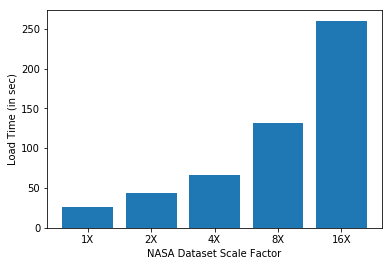

In [9]:
load_times = [26.5, 43.6, 66, 131, 260]
ind = np.arange(len(load_times))
fig, ax = plt.subplots()
ax.set_xticks(ind)
ax.set_xticklabels(('1X', '2X', '4X', '8X', '16X'))
ax.set_ylabel('Load Time (in sec)')
ax.set_xlabel('NASA Dataset Scale Factor')
plt.bar(ind, load_times)

### Query Response Times

In [12]:
%%time
spark_dataframe.groupBy('response_code').count().collect()

CPU times: user 74.1 ms, sys: 27.6 ms, total: 102 ms
Wall time: 2.46 s


[Row(response_code='200', count=1701534),
 Row(response_code='302', count=46573),
 Row(response_code='501', count=14),
 Row(response_code='404', count=10845),
 Row(response_code='403', count=54),
 Row(response_code='500', count=62),
 Row(response_code='304', count=132627),
 Row(response_code='No Value', count=1),
 Row(response_code='400', count=5)]

In [19]:
%%time
sdf2x.groupBy('response_code').count().collect()

CPU times: user 49.9 ms, sys: 44.6 ms, total: 94.5 ms
Wall time: 2.72 s


[Row(response_code='200', count=3403068),
 Row(response_code='302', count=93146),
 Row(response_code='501', count=28),
 Row(response_code='404', count=21690),
 Row(response_code='403', count=108),
 Row(response_code='500', count=124),
 Row(response_code='304', count=265254),
 Row(response_code='No Value', count=2),
 Row(response_code='400', count=10)]

In [20]:
%%time
sdf4x.groupBy('response_code').count().collect()

CPU times: user 74.1 ms, sys: 26.3 ms, total: 100 ms
Wall time: 3.57 s


[Row(response_code='200', count=6806136),
 Row(response_code='302', count=186292),
 Row(response_code='501', count=56),
 Row(response_code='404', count=43380),
 Row(response_code='403', count=216),
 Row(response_code='500', count=248),
 Row(response_code='304', count=530508),
 Row(response_code='No Value', count=4),
 Row(response_code='400', count=20)]

In [21]:
%%time
sdf8x.groupBy('response_code').count().collect()

CPU times: user 73.4 ms, sys: 42.9 ms, total: 116 ms
Wall time: 5.99 s


[Row(response_code='200', count=13612272),
 Row(response_code='302', count=372584),
 Row(response_code='501', count=112),
 Row(response_code='404', count=86760),
 Row(response_code='403', count=432),
 Row(response_code='500', count=496),
 Row(response_code='304', count=1061016),
 Row(response_code='No Value', count=8),
 Row(response_code='400', count=40)]

In [22]:
%%time
sdf16x.groupBy('response_code').count().collect()

CPU times: user 112 ms, sys: 14 ms, total: 126 ms
Wall time: 7.36 s


[Row(response_code='200', count=27224544),
 Row(response_code='302', count=745168),
 Row(response_code='501', count=224),
 Row(response_code='404', count=173520),
 Row(response_code='403', count=864),
 Row(response_code='500', count=992),
 Row(response_code='304', count=2122032),
 Row(response_code='No Value', count=16),
 Row(response_code='400', count=80)]

### Plot GroupBy Query Times

In [13]:
group_by_times = [2.46, 2.72,  3.57, 5.99, 7.36]

<Container object of 5 artists>

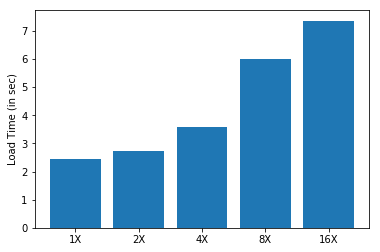

In [14]:
ind = np.arange(len(group_by_times))
fig, ax = plt.subplots()
ax.set_xticks(ind)
ax.set_xticklabels(('1X', '2X', '4X', '8X', '16X'))
ax.set_ylabel('Group by Time (in sec)')
plt.bar(ind, group_by_times)

### 5.7 Strong Scaling

  * Measure the runtime for the query for 8, 16, 32, 64, 128, 256 cores for 1x and 16x datasets!
  * Compute the speedup and efficiency!
  * Plot and explain the responses!

In [ ]:
import os
# Initialize PySpark
APP_NAME = "PySpark Dataframes and Performance"
SPARK_MASTER="spark://mpp3r01c03s03.cos.lrz.de:7077"
os.environ["PYSPARK_PYTHON"] = "/naslx/projects/pn69si/mnmda001/software/anaconda3/bin/python"


def init_spark(number_cores):
    # If there is no SparkSession, create the environment
    APP_NAME = "PySpark Dataframes and Performance (%d)"%number_cores
    try:
        sc and spark
    except NameError as e:
      #import findspark
      #findspark.init()
        import pyspark
        import pyspark.sql
        from pyspark.sql import Row
        conf=pyspark.SparkConf().setAppName(APP_NAME).set("spark.cores.max", str(number_cores))
        sc = pyspark.SparkContext(master=SPARK_MASTER, conf=conf)
        spark = pyspark.sql.SparkSession(sc).builder.appName(APP_NAME).getOrCreate()
    print("PySpark initiated. Cores: %d"%number_cores)
    return sc

from pyspark.sql import Row
import time

for c in [1,2,4,8,16,32,64,128,256,512]:
    sc = init_spark(c)
    nasa_lines = sc.textFile("../data/nasa/NASA_access_log_Jul95")
    spark_dataframe=nasa_lines.map(lambda a: Row(host=a.split()[0], response_code=a.split()[-2] if len(a.split())>2 else "No Value")).toDF()
    sdf16x = spark_dataframe
    for i in range(4): sdf16x = sdf16x.union(sdf16x)
    sdf16x.cache().count()
    spark_dataframe.cache().count()
    
    for i in range(5):
        start = time.time()
        sdf16x.groupBy('response_code').count().collect()
        end = time.time()    
        print("16, %d, %.3f"%(c, end-start))
        time.sleep(2)
        start = time.time()
        spark_dataframe.groupBy('response_code').count().collect()
        end = time.time()
        print("1,  %d, %.3f"%(c, end-start))
        time.sleep(2)
    sc.stop()
    

### Plot Result

In [67]:
import pandas as pd
df = pd.read_csv("performance.csv")

In [75]:
df_agg = df.groupby(['Scale', ' Cores'], as_index=False).agg({' Time': ['std', 'mean']})
df_agg.columns = ['-'.join(col) for col in  df_agg.columns]

MultiIndex(levels=[[' Time', ' Cores', 'Scale'], ['std', 'mean', '']],
           labels=[[2, 1, 0, 0], [2, 2, 0, 1]])

In [76]:
df_agg

,Scale-,Cores-,Time-std,Time-mean
0,1,1,0.817576,6.1581
1,1,2,0.462444,3.5395
2,1,4,0.227183,2.0647
3,1,8,0.405666,1.7826
4,8,1,3.957158,25.0748
5,8,2,0.722123,12.9202
6,8,4,1.010993,7.3240
7,8,8,1.867504,5.9398
8,16,1,3.684847,48.8592
9,16,2,2.118824,22.1822


In [82]:
df_agg.plot(kind='line', x=' Cores-', y=' Time-mean', c=['c', 'y', 'b'],  legend=True)

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x2aefbcf7bd90> (for post_execute):


ValueError: Invalid RGBA argument: ['c', 'y', 'b']

ValueError: Invalid RGBA argument: ['c', 'y', 'b']

In [35]:
df['Cores']

KeyError: 'Cores'

### 5.6 Convert the output to a Pandas dataframe and calculate the percentage of total for each response code!

In [17]:
results["counts_pct"]=(results["count"]/results["count"].sum()*100) 
results

,response_code,count,counts_pct
0,200,1701534,89.946636
1,302,46573,2.461946
2,501,14,0.000740
3,404,10845,0.573289
4,403,54,0.002855
5,500,62,0.003277
6,304,132627,7.010940
7,No Value,1,0.000053
8,400,5,0.000264


## Alternative Implementation

In [28]:
lines = spark.read.format("text").load(os.path.join(os.getcwd(), "../data/nasa/spark-streaming/NASA_access_log_Jul95"))

see <https://stackoverflow.com/questions/40467936/how-do-i-get-the-last-item-from-a-list-using-pyspark>

In [50]:
lines = lines.withColumn('split_value', F.split((lines.value), " "))
lines = lines.withColumn('response_code', lines.split_value[F.size(lines.split_value)-2])
rc_counts = lines.groupBy("response_code").count()

In [51]:
lines.take(5)

[Row(value='199.72.81.55 - - [01/Jul/1995:00:00:01 -0400] "GET /history/apollo/ HTTP/1.0" 200 6245', response_code='200', split_value=['199.72.81.55', '-', '-', '[01/Jul/1995:00:00:01', '-0400]', '"GET', '/history/apollo/', 'HTTP/1.0"', '200', '6245']),
 Row(value='unicomp6.unicomp.net - - [01/Jul/1995:00:00:06 -0400] "GET /shuttle/countdown/ HTTP/1.0" 200 3985', response_code='200', split_value=['unicomp6.unicomp.net', '-', '-', '[01/Jul/1995:00:00:06', '-0400]', '"GET', '/shuttle/countdown/', 'HTTP/1.0"', '200', '3985']),
 Row(value='199.120.110.21 - - [01/Jul/1995:00:00:09 -0400] "GET /shuttle/missions/sts-73/mission-sts-73.html HTTP/1.0" 200 4085', response_code='200', split_value=['199.120.110.21', '-', '-', '[01/Jul/1995:00:00:09', '-0400]', '"GET', '/shuttle/missions/sts-73/mission-sts-73.html', 'HTTP/1.0"', '200', '4085']),
 Row(value='burger.letters.com - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/countdown/liftoff.html HTTP/1.0" 304 0', response_code='304', split_value=['bu

In [52]:
rc_counts.collect()

[Row(response_code='200', count=1701534),
 Row(response_code=None, count=1),
 Row(response_code='302', count=46573),
 Row(response_code='501', count=14),
 Row(response_code='404', count=10845),
 Row(response_code='403', count=54),
 Row(response_code='500', count=62),
 Row(response_code='304', count=132627),
 Row(response_code='400', count=5)]